In [1]:
import sys
import os

# Get the path to the validate_assay folder
module_path = os.path.abspath(os.path.join('..', 'validate_assay'))

# Add the folder to the system path
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
from Bio import Entrez
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from pcrvalidationtools import *

In [6]:
DATA_PATH = "../Data/v4_08262024/"
# Raw (not filtered) since we want to remove all EV sequences (including ones we cannot make FN analysis about) from FP analysis
datasets_file = DATA_PATH + 'enterovirus_metadata.tsv'
collapse_taxonomy_file = DATA_PATH + 'ev_taxonomy_collapse.tsv'

assay_files = [DATA_PATH + f'refseq_rna/assay{i}.tsv' for i in [0, 8, 1, 2]]
assay_names = ['Assay 1', 'Assay 2', 'Assay 3', 'Assay 4']

In [7]:
# Target accessions (all ev)
ev_data = pd.read_csv(datasets_file, sep='\t')
ev_acc = ev_data['Accession'].tolist()

# Predicted hit accessions
assay_hits = [get_accessions(file) for file in assay_files]
assay_mismatches = [mismatches(file, ev_data) for file in assay_files]
# Rename column of mismatches to match assay name
assay_mismatches = [df.rename(columns={'Total Mismatches':name}) for df, name in zip(assay_mismatches, assay_names)]

# Make sets for easy comparison 
ev_acc = set(ev_acc)
assay_hits = [set(hits) for hits in assay_hits]

In [8]:
# Define false positives as target accessions subtracted from all hit accessions
# Print 
for hits, name in zip(assay_hits, assay_names):
    print(name)
    false_pos = hits - ev_acc
    if false_pos: 
        print(false_pos)
    else:
        print('No non-enterovirus hits \n')

Assay 1
No non-enterovirus hits 

Assay 2
No non-enterovirus hits 

Assay 3
No non-enterovirus hits 

Assay 4
No non-enterovirus hits 



In [9]:
# All refseq hits
all_hits = set()
for hits in assay_hits:
    all_hits.update(hits)

In [10]:
# Obtain name, virus taxid for each hit 
# Using code written for false positive analysis (non-enterovirus) 
# Technically could have used datasets for this info 

# Get the summary (esummary) for each accession 
fp_summaries = get_acc_summary(all_hits)
# Format into dataframe 
summary_df = acc_summary_df(fp_summaries)

summary_df

,Accession,Name,Virus Taxonomic ID
0,NC_013695.1,"Enterovirus J strain N203, complete genome",1330521
1,NC_001472.1,"Human enterovirus B, complete genome",138949
2,NC_029905.1,"Enterovirus SEV-gx, complete genome",1826059
3,NC_038306.1,"Human coxsackievirus A2 strain Fleetwood, comp...",33757
4,NC_030454.1,"Enterovirus A114 strain V13-0285, partial genome",2760809
5,NC_004441.1,Porcine enterovirus 9 strain UKG/410/73 polypr...,64141
6,NC_038878.1,"Human rhinovirus NAT001 polyprotein gene, comp...",992230
7,NC_038308.1,"Human enterovirus 68 strain Fermon, complete g...",42789
8,NC_010415.1,"Enterovirus J strain 1631, complete genome",1330521
9,NC_038310.1,"Dromedary camel enterovirus strain 19CC, compl...",1637527


In [11]:
# Identify group to collapse to (species)
ev_txid = 12059
taxids = set(summary_df['Virus Taxonomic ID']) # Taxids we need info for 

# Get taxonomy records 
records = get_taxonomy_records(taxids)
# Format dataframe 
taxonomy_collapse = taxonomy_collapse_df(records, ev_txid)
taxonomy_collapse

,Virus Taxonomic ID,Collapse TaxId,Collapse Name
0,47681,90010,unclassified Enterovirus
1,442851,310907,Enterovirus H
2,138948,138948,Enterovirus A
3,138949,138949,Enterovirus B
4,992230,463676,Rhinovirus C
5,42789,138951,Enterovirus D
6,138950,138950,Enterovirus C
7,2760809,138948,Enterovirus A
8,1826059,2169885,Enterovirus L
9,64141,106966,Enterovirus G


In [12]:
# Merge species data to hits data 
summary_df = summary_df.merge(taxonomy_collapse, on='Virus Taxonomic ID') 

# Remove human enterovirus and rhinovirus from false positive hits analysis 
summary_df = summary_df[~summary_df['Collapse Name'].isin([f'Enterovirus {x}' for x in ['A', 'B', 'C', 'D']])]
summary_df = summary_df[~summary_df['Collapse Name'].str.contains('Rhinovirus')]
summary_df

,Accession,Name,Virus Taxonomic ID,Collapse TaxId,Collapse Name
0,NC_013695.1,"Enterovirus J strain N203, complete genome",1330521,1330521,Enterovirus J
1,NC_010415.1,"Enterovirus J strain 1631, complete genome",1330521,1330521,Enterovirus J
3,NC_029905.1,"Enterovirus SEV-gx, complete genome",1826059,2169885,Enterovirus L
6,NC_004441.1,Porcine enterovirus 9 strain UKG/410/73 polypr...,64141,106966,Enterovirus G
9,NC_038310.1,"Dromedary camel enterovirus strain 19CC, compl...",1637527,2040663,Enterovirus I
11,NC_003988.1,"Simian enterovirus A, complete genome",310907,310907,Enterovirus H
12,NC_024073.1,"Enterovirus sp. isolate CPML_8109/08, complete...",47681,90010,unclassified Enterovirus
13,NC_038309.1,"Simian enterovirus SV4 strain 1715 UWB, comple...",442851,310907,Enterovirus H


In [14]:
# Make new dataframe with accession and species info
false_pos_mismatches = summary_df[['Accession', 'Collapse Name']]
false_pos_mismatches = false_pos_mismatches.sort_values('Collapse Name')
false_pos_mismatches['Label'] = false_pos_mismatches['Accession'] + ' | ' + false_pos_mismatches['Collapse Name']

# Add mismatch counts from each assay
for df in assay_mismatches:
    false_pos_mismatches = false_pos_mismatches.merge(df, on='Accession', how='left')
    
# Remove unnecessary columns 
false_pos_mismatches = false_pos_mismatches[['Label', 'Assay 1', 'Assay 2', 'Assay 3','Assay 4']]

# Set index (for plotting)
false_pos_mismatches = false_pos_mismatches.set_index('Label')
    
false_pos_mismatches

,Assay 1,Assay 2,Assay 3,Assay 4
Label,,,,
NC_004441.1 | Enterovirus G,NaN,0.0,1.0,1.0
NC_003988.1 | Enterovirus H,NaN,NaN,NaN,6.0
NC_038309.1 | Enterovirus H,NaN,NaN,NaN,4.0
NC_038310.1 | Enterovirus I,NaN,NaN,NaN,1.0
NC_013695.1 | Enterovirus J,2.0,0.0,0.0,0.0
NC_010415.1 | Enterovirus J,0.0,1.0,1.0,2.0
NC_029905.1 | Enterovirus L,2.0,NaN,NaN,NaN
NC_024073.1 | unclassified Enterovirus,NaN,0.0,1.0,0.0


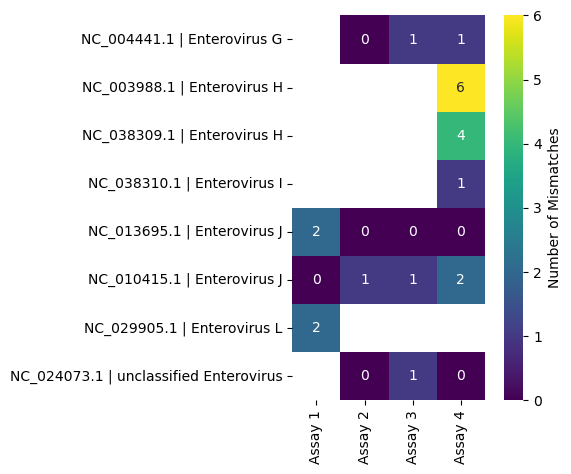

In [16]:
# Plot heatmap
plt.figure(figsize=(5,5))
ax = sns.heatmap(false_pos_mismatches, annot=True, cmap='viridis', square=True, cbar=True)
# Legend 
cbar = ax.collections[0].colorbar
cbar.set_label('Number of Mismatches')
plt.ylabel('')
plt.savefig('false_pos.svg', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
# info for NCBI Entrez
# Entrez.email = # email here
# Entrez.api_key = # API key here 

# returns a list of queries
# each query is a string of comma separated accessions
# this breaks up the requests we send to NCBI
# identifiers (list): list of identifiers (accession number, taxid) strings
def define_query(identifiers):
    # if getting invalid uid error, try lowering batch size
    BATCH_SIZE = 1000
    queries = []
    size = len(identifiers)
    iters = (size // BATCH_SIZE) + (size % BATCH_SIZE > 0)
    
    # make sure the list are strings
    identifiers = list(map(str, identifiers))
    
    for i in range(iters):
        start_range = i * BATCH_SIZE
        end_range = start_range + BATCH_SIZE
        query_str = ", ".join(identifiers[start_range:end_range])
        queries.append(query_str)
    return queries

def get_acc_summary(accessions):
    acc_summaries = []
    queries = define_query(accessions)
    for query in queries:
        handle = Entrez.esummary(db="nucleotide", id=query, retmode="xml")
        summaries = Entrez.read(handle)
        acc_summaries.extend(summaries)
        handle.close()
    return acc_summaries

def acc_taxid_df(summaries):
    df_dict = {'Accession': [], 'Virus Taxonomic ID': []}
    for summary in summaries:
        # Should I use AccessionVersion instead of Caption
        df_dict['Accession'].append(summary['Caption'])
        df_dict['Virus Taxonomic ID'].append(int(summary['TaxId']))
        
    return pd.DataFrame(df_dict)

def acc_summary_df(summaries):
    df_dict = {'Accession': [], 'Name':[], 'Virus Taxonomic ID': []}
    for summary in summaries:
        # Should I use AccessionVersion instead of Caption
        df_dict['Accession'].append(summary['AccessionVersion'])
        df_dict['Name'].append(summary['Title'])
        df_dict['Virus Taxonomic ID'].append(int(summary['TaxId']))
        
    return pd.DataFrame(df_dict)

def taxid_to_name(taxids):
    taxid_to_name = {}
    queries = define_query(taxids)
    for query in queries:
        handle = Entrez.esummary(db="taxonomy", id=query, retmode="xml")
        summaries = Entrez.read(handle)
        handle.close()

        for summary in summaries:
            name = summary['ScientificName']
            txid = summary['TaxId']
            taxid_to_name[txid] = name

    return taxid_to_name

def fp_taxonomy_summary(acc_summary):
    grouped_df = acc_summary.groupby('TaxId')['Accession'].count().reset_index()
    taxids = grouped_df['TaxId']
    taxid_names = taxid_to_name(taxids)
    grouped_df['Taxonomy Name'] = grouped_df['TaxId'].apply(lambda taxid: taxid_names[taxid])
    grouped_df = grouped_df.rename(columns={'Accession': 'Count'})
    return grouped_df

In [4]:
# returns genbank records for the list of accessions
# accessions : list of accession strings
def get_taxonomy_records(taxids):
    taxonomy_records = []
    queries = define_query(taxids)
    for query in queries:
        handle = Entrez.efetch(db="taxonomy", id=query, retmode="xml")
        records = Entrez.read(handle)
        handle.close()
        taxonomy_records.extend(records)
    return taxonomy_records

# returns a df with taxid and corresponding collapse taxid 
def taxonomy_collapse_df(records, target_taxid):
    # parse records and determine collapse taxid 
    df_dict = {'Virus Taxonomic ID': [], 'Collapse TaxId': [], 'Collapse Name': []}
    for record in records:
        
        taxid = int(record['TaxId'])
        collapse_taxid = None
        collapse_name = None
        
        # ordered from top of lineage to bottom (most specific)
        taxonomy_lineage = [node['TaxId'] for node in record['LineageEx']]
        
        # find the collapse taxid
        if str(target_taxid) in taxonomy_lineage:
            # the taxonomy level we want to collapse at is one level below the target 
            collapse_index = taxonomy_lineage.index(str(target_taxid)) + 1 
            # if index within range
            if collapse_index < len(taxonomy_lineage):
                collapse_taxid = taxonomy_lineage[collapse_index] 
                collapse_name = record['LineageEx'][collapse_index]['ScientificName']
            else:
                collapse_taxid = taxid 
                collapse_name = record['ScientificName']
                
        df_dict['Virus Taxonomic ID'].append(int(taxid))
        df_dict['Collapse TaxId'].append(int(collapse_taxid))
        df_dict['Collapse Name'].append(collapse_name)

    # return df
    return pd.DataFrame(df_dict)

In [5]:
def mismatches(assay_file, database_df):
    df = pd.read_csv(assay_file, sep='\t')
    df = df.drop_duplicates(subset=['Full_Hit_ID'], keep='first')
    
    accessions = df['Full_Hit_ID'].str.split(' ').str[0]
    mismatch_counts = df['FP_mismatches'] + df['RP_mismatches'] + df['Probe_mismatches']
    
    mismatch_df = pd.DataFrame({'Accession': accessions, 'Total Mismatches': mismatch_counts})
    
    # remove non targets 
    mismatch_df = mismatch_df[mismatch_df['Accession'].isin(database_df['Accession'])]
    
    return mismatch_df